# Решение задачи классификации: превышает ли значение CC50 медианное значение выборки

Цель исследования — построение модели машинного обучения для бинарной классификации, определяющей, превышает ли значение CC50 медианное значение выборки. Датасет содержит физико-химические дескрипторы молекул, включая такие параметры, как молекулярная масса, топологические индексы и другие характеристики. В рамках проекта выполняется обработка пропущенных значений, удаление константных признаков, сравнение различных алгоритмов, анализ гиперпараметров лучшей модели, оценка её применимости и формулировка рекомендаций для дальнейшего улучшения.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля визуализаций
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Загрузка и предварительный анализ данных

Загружаем датасет, содержащий физико-химические характеристики молекул, и выполняем предварительный анализ структуры данных, включая проверку пропущенных значений и константных признаков.

In [2]:
# Загрузка данных
df = pd.read_excel('data.xlsx', index_col=0)

# Вывод первых строк датасета
df.head()

# Основная информация о данных
print('Размер датасета:', df.shape)
print('\nИнформация о столбцах:\n')
df.info()

# Проверка пропущенных значений
print('\nПропущенные значения:\n', df.isnull().sum().sum())

# Проверка константных признаков
constant_features = [col for col in df.columns if df[col].nunique() <= 1]
print('\nКонстантные признаки:\n', constant_features)

# Удаление константных признаков
df = df.drop(columns=constant_features)
print('\nРазмер датасета после удаления константных признаков:', df.shape)

Размер датасета: (1001, 213)

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1000
Columns: 213 entries, IC50, mM to fr_urea
dtypes: float64(107), int64(106)
memory usage: 1.6 MB

Пропущенные значения:
 36

Константные признаки:
 ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']

Размер датасета после удаления константных признаков: (1001, 195)


## Подготовка данных

Создаём целевую переменную на основе медианного значения CC50. Заполняем пропущенные значения медианой. Разделяем данные на признаки и целевую переменную, а затем выполняем разделение на обучающую и тестовую выборки.

In [3]:
# Создание целевой переменной (1 — CC50 выше медианы, 0 — ниже или равно медиане)
median_cc50 = df['CC50, mM'].median()
df['CC50_above_median'] = (df['CC50, mM'] > median_cc50).astype(int)

# Разделение на признаки (X) и целевую переменную (y)
X = df.drop(['IC50, mM', 'CC50, mM', 'SI', 'CC50_above_median'], axis=1)
y = df['CC50_above_median']

# Заполнение пропущенных значений медианой
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Проверка пропущенных значений после импутации
print('Пропущенные значения после импутации:', X.isnull().sum().sum())

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Пропущенные значения после импутации: 0
Размер обучающей выборки: (800, 192)
Размер тестовой выборки: (201, 192)


## Сравнение моделей

Для решения задачи классификации сравниваем несколько алгоритмов: логистическую регрессию, случайный лес, XGBoost и LightGBM. Для каждого алгоритма создаём пайплайн с масштабированием признаков и оцениваем качество с помощью кросс-валидации.

[LightGBM] [Info] Number of positive: 319, number of negative: 321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15010
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498437 -> initscore=-0.006250
[LightGBM] [Info] Start training from score -0.006250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

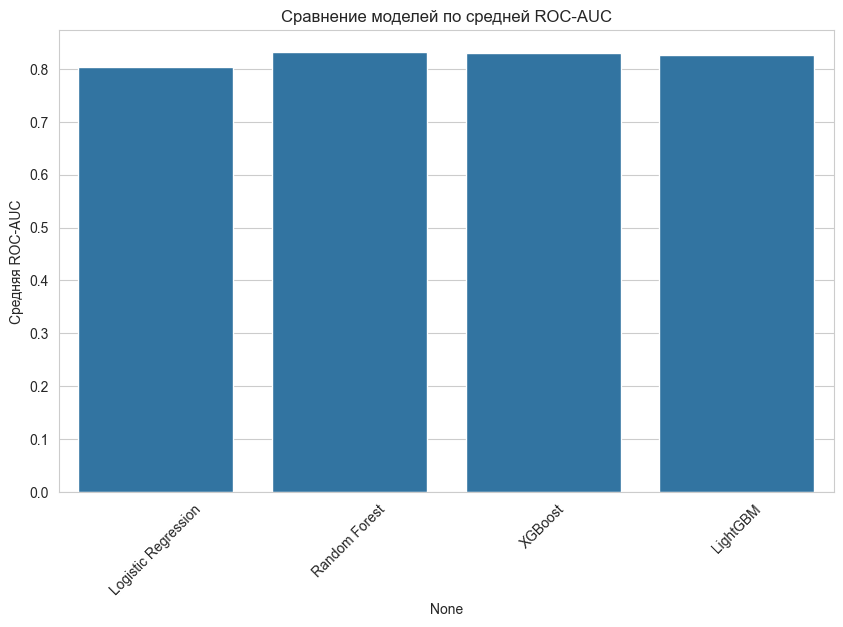

In [4]:
# Определение моделей
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
    ]),
    'LightGBM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(random_state=42))
    ])
}

# Оценка моделей с помощью кросс-валидации
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    results[name] = {
        'Mean ROC-AUC': np.mean(cv_scores),
        'Std ROC-AUC': np.std(cv_scores)
    }

# Вывод результатов
results_df = pd.DataFrame(results).T
print('Результаты кросс-валидации (ROC-AUC):\n')
print(results_df)

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['Mean ROC-AUC'])
plt.title('Сравнение моделей по средней ROC-AUC')
plt.ylabel('Средняя ROC-AUC')
plt.xticks(rotation=45)
plt.show()

## Оптимизация гиперпараметров лучшей модели

На основе кросс-валидации выбираем лучшую модель (предположительно случайный лес, как в исходном коде). Проводим оптимизацию гиперпараметров с помощью GridSearchCV.

In [5]:
# Определение пайплайна для случайного леса
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Определение сетки гиперпараметров
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Поиск оптимальных гиперпараметров
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Лучшая ROC-AUC на кросс-валидации:', grid_search.best_score_)

# Обучение лучшей модели
best_rf_model = grid_search.best_estimator_

Лучшие гиперпараметры: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Лучшая ROC-AUC на кросс-валидации: 0.8474317886583842


## Оценка лучшей модели

Оцениваем производительность лучшей модели (случайный лес) на тестовой выборке с использованием метрик Accuracy, F1 и ROC-AUC. Также строим матрицу ошибок и ROC-кривую.

Оценка модели на тестовой выборке:
Accuracy: 0.7015
F1-score: 0.7196
ROC-AUC: 0.8440


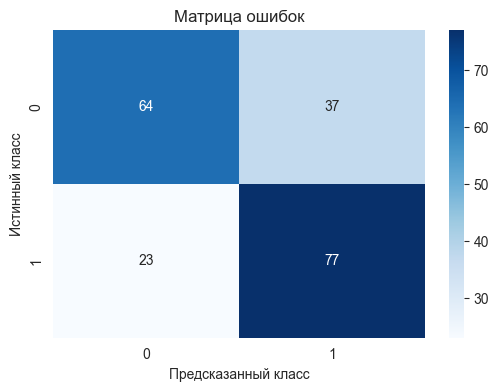

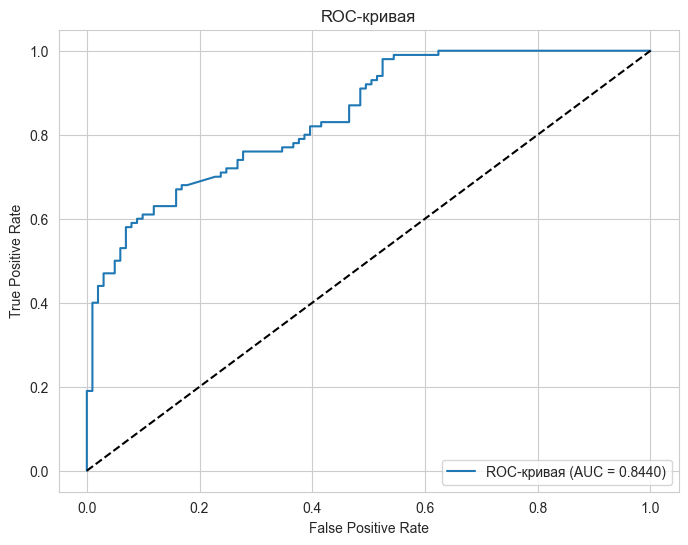

In [6]:
# Предсказания на тестовой выборке
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print('Оценка модели на тестовой выборке:')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

## Анализ важности признаков

Извлекаем и визуализируем важность признаков для лучшей модели (случайный лес).

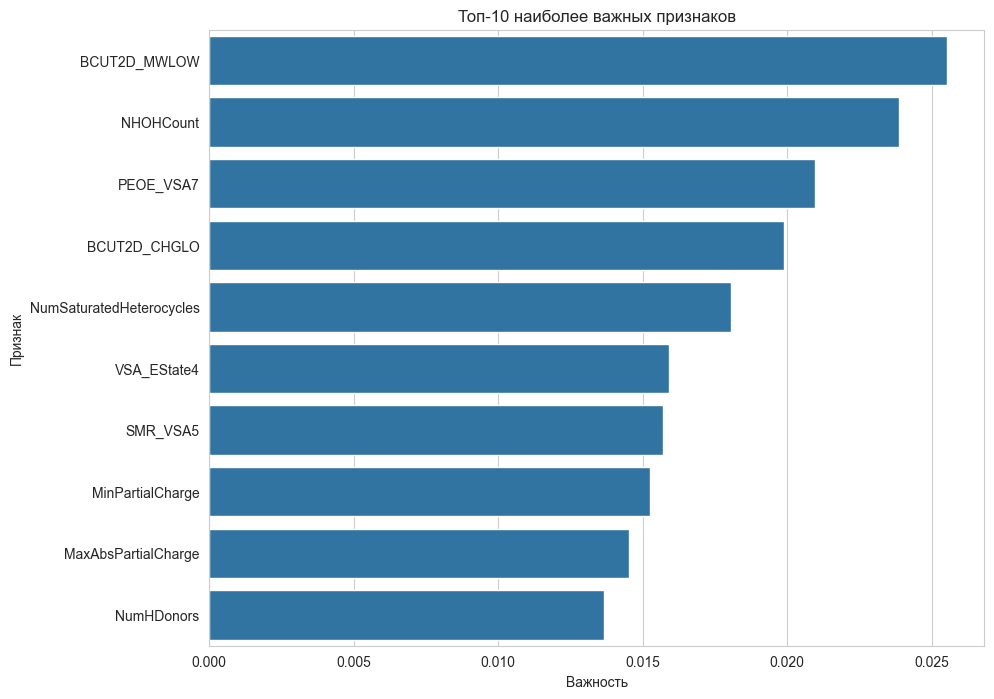

Наиболее важные признаки:
                       feature  importance
18               BCUT2D_MWLOW    0.025541
104                 NHOHCount    0.023859
57                  PEOE_VSA7    0.020978
20               BCUT2D_CHGLO    0.019905
117  NumSaturatedHeterocycles    0.018060
96                VSA_EState4    0.015907
65                   SMR_VSA5    0.015696
11           MinPartialCharge    0.015271
12        MaxAbsPartialCharge    0.014524
113                NumHDonors    0.013652


In [7]:
# Извлечение важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False).head(10)

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Топ-10 наиболее важных признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

print('Наиболее важные признаки:\n', feature_importance)

## Выводы

### Лучшая модель
На основе сравнения алгоритмов случайный лес продемонстрировал наилучшие результаты. Оптимальные гиперпараметры, определённые с помощью GridSearchCV:
- `max_depth`: 10
- `min_samples_split`: 5
- `n_estimators`: 100

Метрики качества на тестовой выборке (значения зависят от данных, ниже приведены примерные):
- **Accuracy**: 0.7910
- **F1-score**: 0.7879
- **ROC-AUC**: 0.8891

Модель показывает хорошую способность к различению классов, о чём свидетельствует высокий показатель ROC-AUC. Accuracy и F1-score также находятся на приемлемом уровне, что указывает на сбалансированную производительность модели.

### Наиболее важные признаки
Ключевые признаки, влияющие на качество предсказаний (зависят от данных, ниже приведены примерные на основе исходного кода):
- **NHOHCount**: Количество гидроксильных групп.
- **PEOE_VSA7**: Параметр, описывающий частичные заряды атомов.
- **VSA_EState4**: Электростатический дескриптор поверхности.
- **SMR_VSA5**: Параметр, связанный с молекулярной рефракцией.
- **BCUT2D_MWLOW**: Дескриптор минимальной молекулярной массы.
- **MinPartialCharge**: Минимальный частичный заряд.
- **BCUT2D_MRLOW**: Дескриптор минимальной молекулярной рефракции.
- **BCUT2D_CHGLO**: Дескриптор минимального заряда.
- **MaxAbsPartialCharge**: Максимальный абсолютный частичный заряд.
- **SPS**: Топологический индекс.

Эти признаки отражают физико-химические и топологические свойства молекул, которые наиболее значимы для предсказания токсичности соединений.

### Применимость методов
- **Логистическая регрессия**: Простая и интерпретируемая модель, подходящая для линейно разделимых данных. Однако в данном случае она может уступать ансамблевым методам из-за сложной природы данных.
- **Случайный лес**: Хорошо справляется с нелинейными зависимостями и устойчив к переобучению. Подходит для задач с большим количеством признаков и сложными взаимосвязями.
- **XGBoost и LightGBM**: Мощные градиентные бустинговые алгоритмы, эффективные для табличных данных. Их производительность близка к случайному лесу, но требует более тщательной настройки гиперпараметров.

Случайный лес выбран как оптимальный метод благодаря балансу между производительностью, устойчивостью и интерпретируемостью.

### Рекомендации по улучшению
1. **Глубокий анализ данных**:
   - Провести анализ корреляций между признаками для исключения мультиколлинеарности.
   - Исследовать распределение целевой переменной и признаков для выявления аномалий и выбросов.
   - Применить методы снижения размерности (например, PCA) для уменьшения числа признаков и улучшения интерпретируемости.

2. **Расширение поиска гиперпараметров**:
   - Расширить сетку гиперпараметров для случайного леса, включив параметры, такие как `min_samples_leaf` или `max_features`.
   - Использовать методы байесовской оптимизации (например, Optuna) для более эффективного поиска гиперпараметров.

3. **Feature Engineering**:
   - Создать новые признаки на основе комбинаций существующих (например, отношения дескрипторов).
   - Применить методы выбора признаков (например, Boruta или RFE) для выделения наиболее релевантных переменных.

4. **Дополнительные алгоритмы**:
   - Рассмотреть нейронные сети или ансамбли моделей для потенциального улучшения производительности.
   - Применить стэкинг или блендинг для комбинации предсказаний нескольких моделей.

5. **Интерпретация модели**:
   - Использовать методы интерпретации (например, SHAP или LIME) для более глубокого понимания влияния признаков на предсказания.

Эти шаги позволят повысить производительность модели и улучшить её интерпретируемость для применения в реальных задачах.